# Evaluation

In [1]:
import json
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

from sklearn import metrics
from rouge import Rouge

import matplotlib.pyplot as plt

## Summary Length

In [2]:
def getDescriptionAndSummary(uri):
    with open(uri) as f:
        ticket = json.load(f)

    desc = ""
    sum = ""
    
    if ticket['Description'] is not None:
        desc = ticket['Description']
    
    if ticket['Summary'] is not None:
        sum = ticket['Summary']
    
    return desc, sum    

### 0-Shot

In [3]:
directory = "./evaluation/summary/gpt-4-0125-preview/0Shot/"

evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "reruns", "ticket_uri", "output_uri", "violation_actual", "violation_predicted", "reference", "summary_original", "summary_old", "length_old", "summary_new", "length_new", "correction_in_range"])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    outputUri = directory + filename

    if not filename.endswith(".json"):
        continue

    with open(outputUri) as f:
        result = json.load(f)

    if (len(result["output"]["summary_new"]) <= 70) & (len(result["output"]["summary_new"]) >= 39):
        in_range = "TRUE"
    else:
        in_range = "FALSE"

    desc, summary_org = getDescriptionAndSummary(result["input_data"]["ticket_uri"])

    new_row = {
        'jira': result["input_data"]["jira"], 
        'ticketId': result["input_data"]["id"], 
        'evolution': result["input_data"]["evolution"], 
        'reruns': result["reruns"],
        'ticket_uri': result["input_data"]["ticket_uri"],
        'output_uri': outputUri, 
        'violation_actual': result["violation_actual"], 
        'violation_predicted': result["output"]["violation_predicted"],
        'reference': summary_org + " : " + desc,
        'summary_original': summary_org,
        'summary_old': result["output"]["summary_old"],
        'length_old': len(result["output"]["summary_old"]), 
        'summary_new': result["output"]["summary_new"],
        'length_new': len(result["output"]["summary_new"]), 
        'correction_in_range': in_range
        }

    evalDF.loc[len(evalDF)]=new_row

# Save data to csv
evalDF.to_csv(directory + "evaluatedSummarys.csv", index=False)

#### Detection

In [6]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 2]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

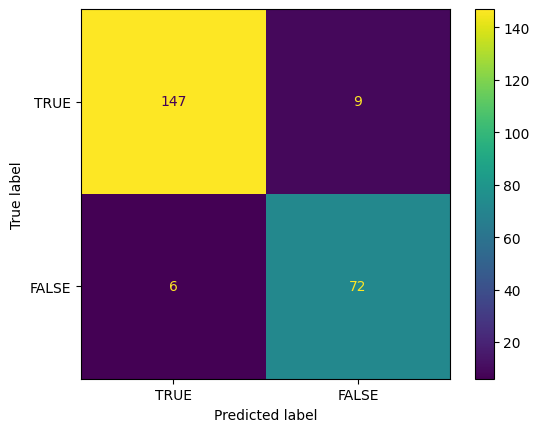

In [7]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label="TRUE")
recall = metrics.recall_score(actual, predicted, pos_label="TRUE")
f05 = metrics.fbeta_score(actual, predicted, beta=0.5, pos_label="TRUE")

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=["TRUE", "FALSE"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["TRUE", "FALSE"])

cm_display.plot()
plt.show()

## Oben Recjts = TP (Verstoß wird erkannt und liegt vor)
## Unten Links = TN (Verstoß wird nicht erkannt und liegt nicht vor)
## Oben Links = FN (Verstoß wird nicht erkannt obwohl einer vorliegt)
## Unten Rechts = FP (Verstoß wird erkannt obwohl keiner vorliegt)

In [8]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F.5: " + str(f05))

Accuracy: 0.9358974358974359
Precision: 0.9607843137254902
Recall: 0.9423076923076923
F.5: 0.95703125


#### Correction

In [9]:
def computeROUGE(reference, predicted):
    rouge = Rouge()
    scores = [rouge.get_scores(new, old) for old, new in zip(reference, predicted)]

    total_scores = {"rouge-1": {"f": 0, "p": 0, "r": 0}, "rouge-2": {"f": 0, "p": 0, "r": 0}, "rouge-l": {"f": 0, "p": 0, "r": 0}}

    for score in scores:
        for key in total_scores.keys():
            total_scores[key]['f'] += score[0][key]['f']
            total_scores[key]['p'] += score[0][key]['p']
            total_scores[key]['r'] += score[0][key]['r']

    for key in total_scores.keys():
        total_scores[key]['f'] /= len(scores)
        total_scores[key]['p'] /= len(scores)
        total_scores[key]['r'] /= len(scores)
    
    return total_scores    

In [10]:
# correctedTickets = evalDF_runs[evalDF_runs["violation_actual"] == "TRUE"]
successRate = evalDF_runs["correction_in_range"].value_counts(normalize=True)["TRUE"]
print("Success rate: " + str(successRate))

Success rate: 0.9615384615384616


In [12]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == "TRUE":
        reference = np.append(reference, row["reference"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Desc):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

Average ROUGE scores (Desc):
{'rouge-1': {'f': 0.2543979375064742, 'p': 0.5904590779590779, 'r': 0.20378983903460202}, 'rouge-2': {'f': 0.09700888482947286, 'p': 0.24323616198616194, 'r': 0.08253714973442045}, 'rouge-l': {'f': 0.21940516649419173, 'p': 0.5185925185925188, 'r': 0.1760726896441573}}


In [13]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == "TRUE":
        reference = np.append(reference, row["summary_original"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Sum):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

Average ROUGE scores (Sum):
{'rouge-1': {'f': 0.38932689997240816, 'p': 0.4314229751729754, 'r': 0.408455684008643}, 'rouge-2': {'f': 0.15862334022595656, 'p': 0.17969067969067962, 'r': 0.16419023905627853}, 'rouge-l': {'f': 0.353436093002677, 'p': 0.3906207218707221, 'r': 0.37309678675033514}}


### 0Shot CoT

In [14]:
directory = "./evaluation/summary/gpt-4-0125-preview/0ShotCoT/"

evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "reruns", "ticket_uri", "output_uri", "violation_actual", "violation_predicted", "reference", "summary_original", "summary_old", "length_old", "summary_new", "length_new", "correction_in_range"])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    outputUri = directory + filename

    if not filename.endswith(".json"):
        continue

    with open(outputUri) as f:
        result = json.load(f)

    if (len(result["output"]["summary_new"]) <= 70) & (len(result["output"]["summary_new"]) >= 39):
        in_range = "TRUE"
    else:
        in_range = "FALSE"

    desc, summary_org = getDescriptionAndSummary(result["input_data"]["ticket_uri"])

    new_row = {
        'jira': result["input_data"]["jira"], 
        'ticketId': result["input_data"]["id"], 
        'evolution': result["input_data"]["evolution"], 
        'reruns': result["reruns"],
        'ticket_uri': result["input_data"]["ticket_uri"],
        'output_uri': outputUri, 
        'violation_actual': result["violation_actual"], 
        'violation_predicted': result["output"]["violation_predicted"],
        'reference': summary_org + " : " + desc,
        'summary_original': summary_org,
        'summary_old': result["output"]["summary_old"],
        'length_old': len(result["output"]["summary_old"]), 
        'summary_new': result["output"]["summary_new"],
        'length_new': len(result["output"]["summary_new"]), 
        'correction_in_range': in_range
        }

    evalDF.loc[len(evalDF)]=new_row

# Save data to csv
evalDF.to_csv(directory + "evaluatedSummarys.csv", index=False)

#### Detection

In [15]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 2]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

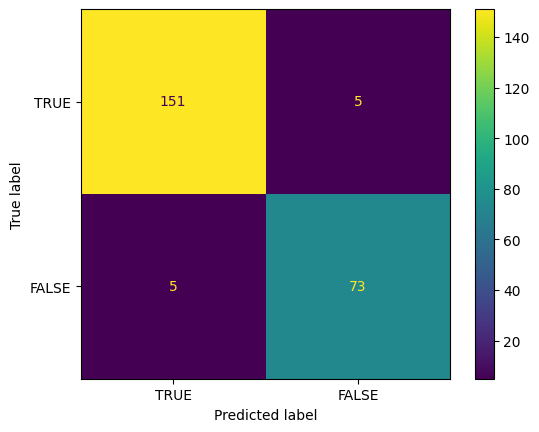

In [16]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label="TRUE")
recall = metrics.recall_score(actual, predicted, pos_label="TRUE")
f05 = metrics.fbeta_score(actual, predicted, beta=0.5, pos_label="TRUE")

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=["TRUE", "FALSE"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["TRUE", "FALSE"])

cm_display.plot()
plt.show()

## Oben Recjts = TP (Verstoß wird erkannt und liegt vor)
## Unten Links = TN (Verstoß wird nicht erkannt und liegt nicht vor)
## Oben Links = FN (Verstoß wird nicht erkannt obwohl einer vorliegt)
## Unten Rechts = FP (Verstoß wird erkannt obwohl keiner vorliegt)

In [17]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F.5: " + str(f05))

Accuracy: 0.9572649572649573
Precision: 0.967948717948718
Recall: 0.967948717948718
F.5: 0.967948717948718


#### Correction

In [18]:
def computeROUGE(reference, predicted):
    rouge = Rouge()
    scores = [rouge.get_scores(new, old) for old, new in zip(reference, predicted)]

    total_scores = {"rouge-1": {"f": 0, "p": 0, "r": 0}, "rouge-2": {"f": 0, "p": 0, "r": 0}, "rouge-l": {"f": 0, "p": 0, "r": 0}}

    for score in scores:
        for key in total_scores.keys():
            total_scores[key]['f'] += score[0][key]['f']
            total_scores[key]['p'] += score[0][key]['p']
            total_scores[key]['r'] += score[0][key]['r']

    for key in total_scores.keys():
        total_scores[key]['f'] /= len(scores)
        total_scores[key]['p'] /= len(scores)
        total_scores[key]['r'] /= len(scores)
    
    return total_scores  

In [19]:
# correctedTickets = evalDF_runs[evalDF_runs["violation_actual"] == "TRUE"]
successRate = evalDF_runs["correction_in_range"].value_counts(normalize=True)["TRUE"]
print("Success rate: " + str(successRate))

Success rate: 0.9743589743589743


In [20]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == "TRUE":
        reference = np.append(reference, row["reference"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Desc):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

Average ROUGE scores (Desc):
{'rouge-1': {'f': 0.24519401641578062, 'p': 0.5632672882672883, 'r': 0.19816582895695792}, 'rouge-2': {'f': 0.08531707344896662, 'p': 0.21850071225071213, 'r': 0.07239635484330695}, 'rouge-l': {'f': 0.2144814686343232, 'p': 0.5004537129537131, 'r': 0.1727823015040019}}


In [21]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == "TRUE":
        reference = np.append(reference, row["summary_old"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Sum):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

Average ROUGE scores (Sum):
{'rouge-1': {'f': 0.37072048652805434, 'p': 0.4087845025345026, 'r': 0.39244095471158463}, 'rouge-2': {'f': 0.14463960029332298, 'p': 0.166857448107448, 'r': 0.14938799337167996}, 'rouge-l': {'f': 0.34457977662852046, 'p': 0.38011895511895527, 'r': 0.36531630240310875}}


# Update

In [ ]:
directory = "./evaluation/update/gpt-4-0125-preview/"

In [ ]:
evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "reruns", "ticket_uri", "output_uri", "violation_actual", "violation_predicted", "change_actual", "change_predicted", "success"])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    outputUri = directory + filename

    if not filename.endswith(".json"):
        continue

    with open(outputUri) as f:
        result = json.load(f)

    new_row = {
        'jira': result["input_data"]["jira"], 
        'ticketId': result["input_data"]["id"], 
        'evolution': result["input_data"]["evolution"],
        'reruns': result["reruns"],
        'ticket_uri': result["input_data"]["ticket_uri"],
        'output_uri': outputUri, 
        'violation_actual': result["violation_actual"], 
        'violation_predicted': result["output"]["violation_predicted"],
        'change_actual': result["reason"],
        'change_predicted': result["output"]["fields"],
        'success': None
        }

    evalDF.loc[len(evalDF)]=new_row    

# Save data to csv
evalDF.to_csv(directory + "updateSummarys.csv", index=False)

#### Detection

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label="TRUE")
recall = metrics.recall_score(actual, predicted, pos_label="TRUE")
f05 = metrics.fbeta_score(actual, predicted, beta=0.5, pos_label="TRUE")

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=["TRUE", "FALSE"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["TRUE", "FALSE"])

cm_display.plot()
plt.show()

In [ ]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F05: " + str(f05))

#### Correction

In [ ]:
evalDF = pd.read_csv(directory + "updateSummarys_labeled.csv")

In [ ]:
successRate = evalDF["success"].value_counts(normalize=True)[True]
print("Success rate: " + str(successRate))